# Single-mode fiber coupling

In this notebook, we calculate the coupling efficiency of a beam with a single-mode optical fiber assuming no internal losses.

Then, we see how to choose the focal length that maximizes the coupling efficiency.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here, we define some functions to model the beam and the fiber mode.

In [2]:
def multivar_gaussian(X, Y, M1, M2):

    S = np.asarray([X, Y])
    S = np.moveaxis(S, 0, 2) - M1

    A = np.linalg.inv(M2)

    B = np.einsum('ij, lmj -> ilm', A, S)
    C = np.einsum('ijk, kij -> ij', S, B)

    g = np.exp(- 0.5 * C)

    return g


def elliptical_beam(fov, n_pixels, waist, wavelength = 640e-9, focal_length = None):

    sigma = np.asarray(waist) / 4
    var = 2 * sigma**2
    
    if focal_length is not None:
        var = wavelength**2 * focal_length **2  / ( 4* np.pi**2 * var )
        
    var_matrix = np.matrix([[var[0], 0], [0, var[1]]])

    x = np.linspace(-0.5*fov, 0.5*fov, num = n_pixels)
    xx, yy = np.meshgrid(x, x)
    
    g = multivar_gaussian(xx, yy, [0, 0], var_matrix)

    return g / g.max()


def fiber_mode(fov, n_pixels, mfd):
    
    sigma = mfd / 4
    var = 2 * sigma**2
    var_matrix = np.matrix([[var, 0], [0, var]])

    x = np.linspace(-0.5*fov, 0.5*fov, num = n_pixels)
    xx, yy = np.meshgrid(x, x)

    g = multivar_gaussian(xx, yy, [0, 0], var_matrix)

    return g / g.max()


def overlap_integral(e1, e2):

    overlap = np.abs( np.sum( e1.conj() * e2 ) )**2
    i1 = np.sum(np.abs(e1)**2)
    i2 = np.sum(np.abs(e2)**2)

    return overlap / i1 / i2

In this example, we consider an elliptical Gaussian beam. However, the method exposed in this notebook is general and can be used for any beam shape.

In [3]:
mfd = 2e-6  # mode field diameter, meters
waist = np.asarray([1.5, 3.5]) * 1e-3  # beam size defined as 1/e^2 or 4sigma, meters
wavelength = 640e-9  # meters

We choose a focal length and define the field of view for the simulation

In [4]:
focal_length = 10e-3  # meters
fov = 4*mfd # meters
n_pixels = 1000

<a list of 1 text.Text objects>

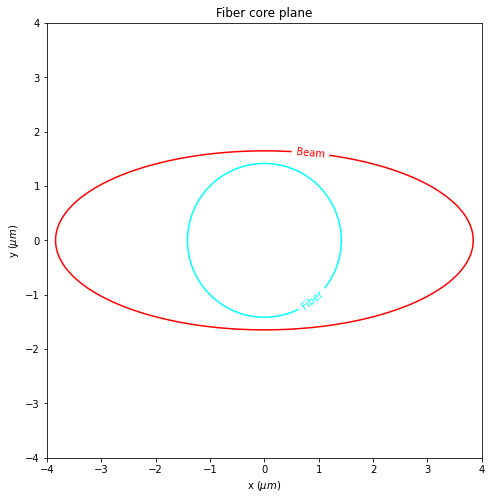

In [5]:
g = elliptical_beam(fov, n_pixels, waist, wavelength = wavelength, focal_length = focal_length)

m = fiber_mode(fov, n_pixels, mfd)

extent = (-0.5*fov*1e6, 0.5*1e6*fov, -0.5*1e6*fov, 0.5*1e6*fov)

plt.figure(figsize = (8, 8))
l1 = plt.contour(g, [g.max()/np.exp(2)], cmap = 'autumn', extent = extent)
l2 = plt.contour(m, [m.max()/np.exp(2)], cmap = 'cool', extent = extent)
plt.gca().set_aspect('equal')
plt.xlabel(r'x ($\mu m)$')
plt.ylabel(r'y ($\mu m)$')
plt.title('Fiber core plane')

plt.gca().clabel(l1, l1.levels, fmt = 'Beam', inline=True, fontsize=10)
plt.gca().clabel(l2, l2.levels, fmt = 'Fiber', inline=True, fontsize=10)

The coupling efficiency is given by the normalized overlap integral
$$\eta  = \frac{{{{\left| {\int {E_1^*{E_2}\;{\rm{d}^2}x} } \right|}^2}}}{{\int {{{\left| {{E_1}} \right|}^2}{\rm{d}^2}x\;\int {{{\left| {{E_2}} \right|}^2}{\rm{d}^2}x} } }} $$
where $E_1$ is the electric field of the incident beam and $E_2$ is the mode supported by the single-mode optical fiber.

In [6]:
coupling_efficiency = overlap_integral(g, m)
print(f'Coupling efficiency = {coupling_efficiency:.3f}')

Coupling efficiency = 0.643


Now, we define a function that looks for the focal lenght that maximizes the efficiency.

In [7]:
from scipy.optimize import minimize

def loss_function(focal_length, fov, n_pixels, mfd, waist, wavelength):

    g = elliptical_beam(fov, n_pixels, waist, wavelength, focal_length)
    m = fiber_mode(fov, n_pixels, mfd)

    efficiency = overlap_integral(g, m)
    loss =  np.abs(1 - efficiency)

    return loss


def find_focal_length(f0, mfd, waist, wavelength):

    fov = 4*mfd
    n_pixels = 501
    
    result = minimize(loss_function, x0=f0, args = (fov, n_pixels, mfd, waist, wavelength))

    return result

Using a single-valued starting point, the algorithm looks for a single focal length, assumed to be identical on both axes.

In [8]:
f0 = 1e-2  #starting point, meters 
#f0 = np.asarray([1e-2, 1e-2])  # if initialized with 2-elements array, it returns two focal lenghts

result = find_focal_length(f0, mfd, waist, wavelength)
print(result)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.15999987071906707
        x: [ 5.624e-03]
      nit: 7
      jac: [ 4.053e-06]
 hess_inv: [[ 2.244e-05]]
     nfev: 28
     njev: 14


In [9]:
foc = np.asarray(result.x)
print('Optimal focal length = ' + np.array2string(1e3*foc, precision=2, separator = ', ') + ' mm')

Optimal focal length = [5.62] mm


We plot the overlap of the beam and the fiber mode with the optimal focal length

<a list of 1 text.Text objects>

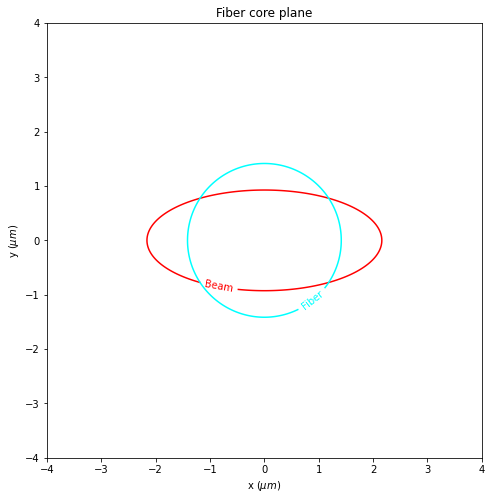

In [10]:
g = elliptical_beam(fov, n_pixels, waist, wavelength = wavelength, focal_length = foc)
m = fiber_mode(fov, n_pixels, mfd)

plt.figure(figsize = (8, 8))
l1 = plt.contour(g, [g.max()/np.exp(2)], cmap = 'autumn', extent = extent)
l2 = plt.contour(m, [m.max()/np.exp(2)], cmap = 'cool', extent = extent)
plt.gca().set_aspect('equal')
plt.xlabel(r'x ($\mu m)$')
plt.ylabel(r'y ($\mu m)$')
plt.title('Fiber core plane')

plt.gca().clabel(l1, l1.levels, fmt = 'Beam', inline=True, fontsize=10)
plt.gca().clabel(l2, l2.levels, fmt = 'Fiber', inline=True, fontsize=10)

The best coupling efficiency is

In [11]:
coupling_efficiency = overlap_integral(g, m)
print(f'Optimal coupling efficiency = {coupling_efficiency:.3f}')

Optimal coupling efficiency = 0.840


Using a starting point with two values, the algorithm looks for a different focal length for each axis.

In [12]:
f0 = np.asarray([1e-2, 1e-2]) 

result = find_focal_length(f0, mfd, waist, wavelength)
print(result)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.360334150353083e-12
        x: [ 3.682e-03  8.590e-03]
      nit: 8
      jac: [ 7.607e-06  9.462e-07]
 hess_inv: [[ 1.382e-05  1.823e-07]
            [ 1.823e-07  7.392e-05]]
     nfev: 51
     njev: 17


In [13]:
foc = np.asarray(result.x)
print('Optimal focal lengths = ' + np.array2string(1e3*foc, precision=2, separator = ', ') + ' mm')

Optimal focal lengths = [3.68, 8.59] mm


<a list of 1 text.Text objects>

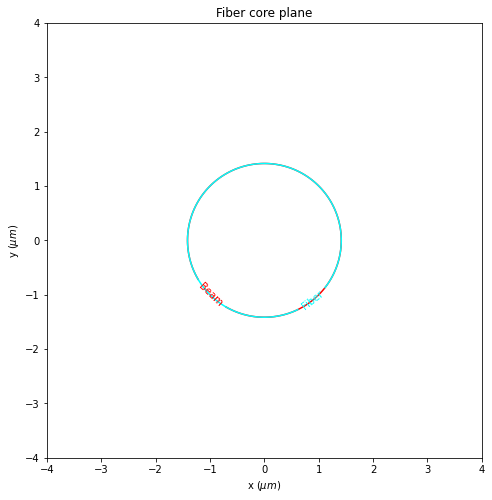

In [14]:
g = elliptical_beam(fov, n_pixels, waist, wavelength = wavelength, focal_length = foc)
m = fiber_mode(fov, n_pixels, mfd)

plt.figure(figsize = (8, 8))
l1 = plt.contour(g, [g.max()/np.exp(2)], cmap = 'autumn', extent = extent)
l2 = plt.contour(m, [m.max()/np.exp(2)], cmap = 'cool', extent = extent)
plt.gca().set_aspect('equal')
plt.xlabel(r'x ($\mu m)$')
plt.ylabel(r'y ($\mu m)$')
plt.title('Fiber core plane')

plt.gca().clabel(l1, l1.levels, fmt = 'Beam', inline=True, fontsize=10)
plt.gca().clabel(l2, l2.levels, fmt = 'Fiber', inline=True, fontsize=10)

In [15]:
coupling_efficiency = overlap_integral(g, m)
print(f'Optimal coupling efficiency = {coupling_efficiency:.3f}')

Optimal coupling efficiency = 1.000


In the case of Gaussian beam, the optimal focal length can be calculated analytically without the need for a numerical minimizer.

The focal length that maximizes the coupling efficiency is

$$ f = \frac{\pi  w  \mu }{4\lambda}$$

where $\lambda$ is the wavelength of the beam, $\mu$ is the mode field diameter (MFD) of the optical fiber, and $w$ is the beam waist (4$\sigma$) measured at the aperture plane of the lens.

If the beam is elliptical, the effective waist is calculated as the geometrical mean of the waist on the two axes.

$$w = \sqrt{ w_x \cdot w_y }$$

In [16]:
# analytic solution

waist_eff = np.sqrt( np.prod( waist ) )  # geometric mean of the waist on the 2 axes

optimal_focal_length = np.pi*waist_eff*mfd/wavelength/4  # meters

print('Optimal focal length = ' + np.array2string(1e3*optimal_focal_length, precision=2, separator = ', ') + ' mm')

Optimal focal length = 5.62 mm


In [17]:
optimal_focal_length = np.pi*waist*mfd/wavelength/4  # meters

print('Optimal focal lengths = ' + np.array2string(1e3*optimal_focal_length, precision=2, separator = ', ') + ' mm')

Optimal focal lengths = [3.68, 8.59] mm
